In [1]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Limit GPU Memory Growth to only what's needed
import tensorflow as tf 
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Failed to limit GPU memory')

In [3]:
#Gather Pre-proccessed images 

train_path = 'dataset-classification/train-segmented'
valid_path = 'dataset-classification/validate-segmented'

train_generator = ImageDataGenerator().flow_from_directory(train_path, target_size=(590,455))
valid_generator = ImageDataGenerator().flow_from_directory(valid_path, target_size=(590,455))


Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [4]:
#Build Model 

base_model = MobileNetV3Large(weights='imagenet', include_top = False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs = preds)


12683000/12683000 [==============================] - 2s 0us/step


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

In [6]:
for layers in model.layers[:-4]:
    layers.trainable = False
    

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

In [8]:
epochs = 20

optimizer = Adam(learning_rate = 0.0001)

model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

model.fit(train_generator, validation_data=valid_generator, epochs = epochs)

Epoch 1/20
75/75 [==============================] - 89s 605ms/step - loss: 0.6426 - accuracy: 0.7675 - val_loss: 0.4576 - val_accuracy: 0.8067
Epoch 2/20
75/75 [==============================] - 20s 267ms/step - loss: 0.3124 - accuracy: 0.9067 - val_loss: 0.2711 - val_accuracy: 0.9133
Epoch 3/20
75/75 [==============================] - 18s 241ms/step - loss: 0.1847 - accuracy: 0.9488 - val_loss: 0.1721 - val_accuracy: 0.9300
Epoch 4/20
75/75 [==============================] - 19s 248ms/step - loss: 0.1191 - accuracy: 0.9675 - val_loss: 0.1179 - val_accuracy: 0.9633
Epoch 5/20
75/75 [==============================] - 21s 284ms/step - loss: 0.0839 - accuracy: 0.9821 - val_loss: 0.0871 - val_accuracy: 0.9833
Epoch 6/20
75/75 [==============================] - 20s 271ms/step - loss: 0.0583 - accuracy: 0.9892 - val_loss: 0.0985 - val_accuracy: 0.9667
Epoch 7/20
75/75 [==============================] - 20s 267ms/step - loss: 0.0504 - accuracy: 0.9900 - val_loss: 0.0726 - val_accuracy: 0.9767

In [9]:
test_path = 'dataset-classification/test-segmented'
test_generator = ImageDataGenerator().flow_from_directory(test_path, target_size=(590,455))
predictions = model.predict(x = test_generator, verbose = 0)

Found 300 images belonging to 3 classes.


In [10]:
test_labels = test_generator.classes
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
test_generator.class_indices

{'-K': 0, '-N': 1, 'FN': 2}

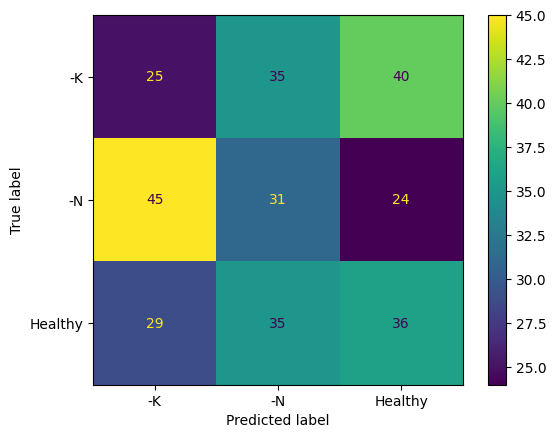

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-K', '-N', 'Healthy'])
disp.plot()
plt.show()

In [12]:
from sklearn.metrics import classification_report 

print(classification_report(y_true=test_labels,y_pred=predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.25      0.25      0.25       100
           1       0.31      0.31      0.31       100
           2       0.36      0.36      0.36       100

    accuracy                           0.31       300
   macro avg       0.31      0.31      0.31       300
weighted avg       0.31      0.31      0.31       300



In [ ]:
#model.save("MNetLarge.h5")